# Historical Efficient Frontier

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf # https://github.com/ranaroussi/yfinance

In [2]:
user_input = {
    'tickers':['AARTIIND','ADANIENT','CONCOR', 'CUMMINSIND','DEEPAKNTR','GUJGASLTD', 'ITC', 'TECHM', 'UPL'],
    'risk_free_rate': 0.08
}

In [3]:
tickers = [i+".NS" for i in user_input["tickers"]]

In [4]:
start_time = datetime.now().timestamp()
yf_data = yf.download(
    tickers = tickers,
    start = datetime.now()-timedelta(days=365*10),
    end = datetime.now(),
    period='5y',
    interval='1d',
    group_by='ticker'
)
end_time = datetime.now().timestamp()
print(f"Time Take to fetch: {round(end_time-start_time)} seconds")

[*********************100%***********************]  9 of 9 completed
Time Take to fetch: 3 seconds


In [5]:
df = pd.DataFrame()
for i in tickers:
    df[i.replace(".NS", "")] = yf_data[i]["Adj Close"]

In [6]:
df.head()

,AARTIIND,ADANIENT,CONCOR,CUMMINSIND,DEEPAKNTR,GUJGASLTD,ITC,TECHM,UPL
Date,,,,,,,,,
2010-07-26,15.419174,72.263397,180.001709,331.111786,NaN,NaN,77.770187,148.478317,101.245430
2010-07-27,15.345255,74.530609,178.574524,330.718781,NaN,NaN,78.168655,143.023529,105.168503
2010-07-28,15.300906,75.114883,178.238464,345.457886,NaN,NaN,78.964867,144.271652,102.656143
2010-07-29,15.138290,73.984436,177.889755,344.531891,NaN,NaN,79.671646,141.453293,101.104027
2010-07-30,15.256556,74.155884,177.521561,357.333344,NaN,NaN,79.324806,140.959656,103.983025


In [7]:
print(f"From: {df.index[0].strftime('%a, %b %d %Y')}\n\nTo: {df.index[-1].strftime('%a, %b %d %Y')}")

From: Mon, Jul 26 2010

To: Mon, Jul 20 2020


In [8]:
# Adjust Historical Range
df = df.loc["2018":"2020"]

In [9]:
df.head()

,AARTIIND,ADANIENT,CONCOR,CUMMINSIND,DEEPAKNTR,GUJGASLTD,ITC,TECHM,UPL
Date,,,,,,,,,
2018-01-01,564.592102,89.268990,530.689819,849.593445,225.123734,166.946167,240.196548,475.047333,493.725555
2018-01-02,560.583984,88.113091,523.701782,858.200562,227.665863,167.509796,238.777176,485.292358,505.288818
2018-01-03,569.960876,94.725616,530.418823,866.621521,228.252502,172.691330,239.143448,490.485687,506.824402
2018-01-04,568.723755,98.542595,532.838562,905.330444,229.279129,168.014114,239.509750,493.412750,510.646118
2018-01-05,579.238708,103.838303,534.000000,890.674988,237.394348,172.236450,240.746002,496.151093,505.778778


In [10]:
returns = df.pct_change().dropna()

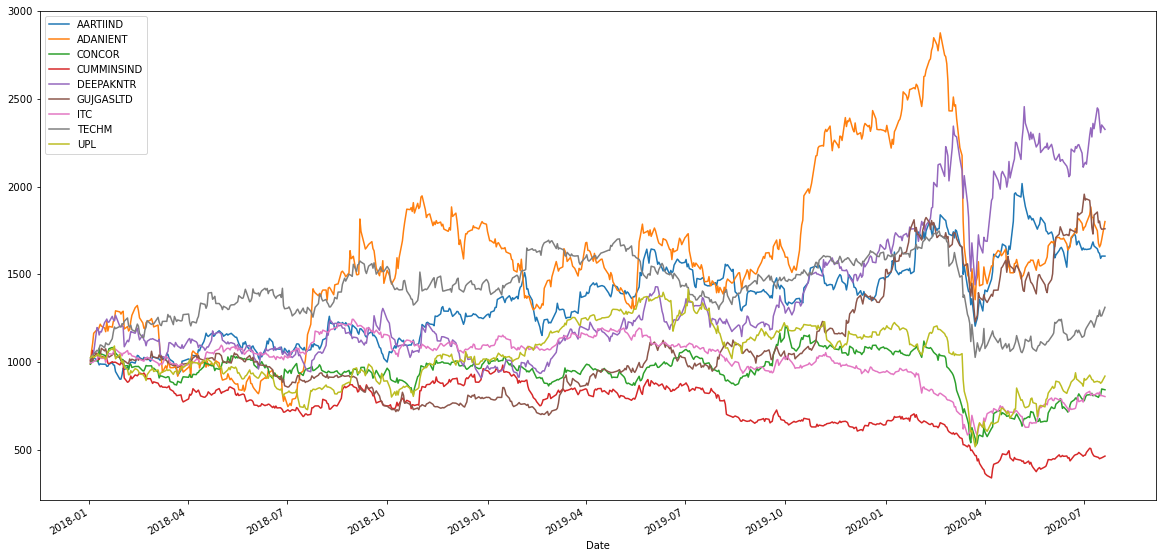

In [11]:
# Individual assets with Rs. 1000 starting balance
((returns+1).cumprod()*1000).plot(figsize=[20,10])

In [12]:
annulized_returns = (returns+1).prod()**(252/returns.shape[0])-1

In [13]:
annulized_returns

AARTIIND      0.210363
ADANIENT      0.268451
CONCOR       -0.067698
CUMMINSIND   -0.267867
DEEPAKNTR     0.406951
GUJGASLTD     0.256706
ITC          -0.085264
TECHM         0.115803
UPL          -0.033662
dtype: float64

In [14]:
annulized_volatility = returns.std()*(252**0.5)

In [15]:
annulized_volatility

AARTIIND      0.355529
ADANIENT      0.540371
CONCOR        0.368712
CUMMINSIND    0.353885
DEEPAKNTR     0.441679
GUJGASLTD     0.354099
ITC           0.294404
TECHM         0.333549
UPL           0.412783
dtype: float64

In [16]:
# Portfolio Return and Portfolio Volatilty

def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

In [17]:
from scipy.optimize import minimize

def minimize_vol(target_return, returns, cov):
    n = returns.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # Range of allowed weights
    
    # Defining the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (returns,),
                        'fun': lambda weights, returns: target_return - portfolio_return(weights,returns)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

def calc_optimal_weights(n_points, returns, cov):
    target_rs = np.linspace(returns.min(), returns.max(), n_points)
    weights = [minimize_vol(target_return, returns, cov) for target_return in target_rs]
    return weights

In [18]:
n = 50 # Number of points on the efficient frontier

## Optimal Weights values will hover on each point of the 2d efficient frontier curve

In [19]:
optimal_weights = calc_optimal_weights(n, annulized_returns, returns.cov())

In [20]:
df_optimal_weights = pd.DataFrame(optimal_weights)
df_optimal_weights.columns = df.columns
df_optimal_weights = df_optimal_weights*100

In [21]:
# Values are in percentage
df_optimal_weights.head()

,AARTIIND,ADANIENT,CONCOR,CUMMINSIND,DEEPAKNTR,GUJGASLTD,ITC,TECHM,UPL
0,2.498002e-14,0.000000e+00,1.110223e-14,99.999999,1.110223e-14,0.000000e+00,0.000001,0.000000e+00,5.551115e-15
1,0.000000e+00,3.053113e-14,0.000000e+00,92.458079,2.220446e-14,1.526557e-14,7.541921,0.000000e+00,8.326673e-15
2,1.081667e-17,0.000000e+00,0.000000e+00,84.916157,2.135694e-16,8.062454e-16,15.083843,0.000000e+00,0.000000e+00
3,0.000000e+00,3.934299e-16,0.000000e+00,77.374236,1.359588e-15,0.000000e+00,22.625764,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,69.832314,6.024894e-16,0.000000e+00,30.167686,1.254126e-16,1.444444e-16


In [22]:
# Returns for each optimal weight
portfolio_returns = [portfolio_return(w, annulized_returns) for w in optimal_weights]
portfolio_volatility = [portfolio_vol(w, returns.cov()) for w in optimal_weights]

In [23]:
efficient_frontier_df = pd.DataFrame(
    {
        "PortfolioReturns": portfolio_returns,
        "PortfolioVolatility": portfolio_volatility
    }
)

In [24]:
efficient_frontier_df.head()

,PortfolioReturns,PortfolioVolatility
0,-0.267867,0.022293
1,-0.254095,0.020919
2,-0.240323,0.019647
3,-0.226551,0.018500
4,-0.212780,0.017501


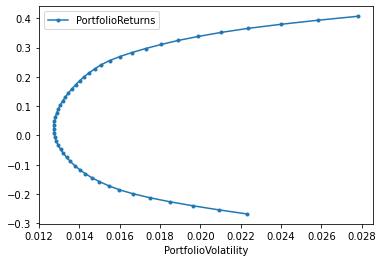

In [25]:
efficient_frontier_df.plot.line(x="PortfolioVolatility", y="PortfolioReturns", style=".-")

In [26]:
efficient_frontier_df.head()

,PortfolioReturns,PortfolioVolatility
0,-0.267867,0.022293
1,-0.254095,0.020919
2,-0.240323,0.019647
3,-0.226551,0.018500
4,-0.212780,0.017501


In [27]:
efficient_frontier_df["SharpeRatio"] = (efficient_frontier_df["PortfolioReturns"] - user_input["risk_free_rate"])/efficient_frontier_df["PortfolioVolatility"]

In [28]:
# Also Hover sharpe ratios along with the weights

efficient_frontier_df.sort_values("SharpeRatio", ascending=False).head()

,PortfolioReturns,PortfolioVolatility,SharpeRatio
44,0.338092,0.019900,12.969508
43,0.324320,0.018899,12.927878
45,0.351864,0.021035,12.924490
42,0.310548,0.018048,12.774334
46,0.365635,0.022377,12.764675


# Maximum Sharpe Ratio with risk free rate

Sharpe Ratio = (`Return of portfolio - Risk Free Rate`) / `Risk of portfolio`

In [29]:
# Maximum Sharpe Ratio

def max_sharp_ratio(returns, cov, riskfree_rate = 0.07):
    
    n = returns.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, returns, cov):
        r = portfolio_return(weights, returns)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, 
                       init_guess,
                       args=(riskfree_rate, returns, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [30]:
msr_weights = max_sharp_ratio(annulized_returns, returns.cov())

In [31]:
# This is the maximum sharpe ratio weight
# Plot this point with a different color on the graph
msr_weights

array([7.49262869e-02, 2.84435642e-02, 2.12016138e-14, 6.21646758e-14,
       5.29403859e-01, 3.67226289e-01, 6.71314248e-15, 2.41091756e-13,
       1.74953636e-14])

In [32]:
msr_return = portfolio_return(msr_weights, annulized_returns)
msr_volatility = portfolio_vol(msr_weights, returns.cov())

In [33]:
print(f"Return: {msr_return}\nVolatility: {msr_volatility}")

Return: 0.33310776727243546
Volatility: 0.019521057381159296


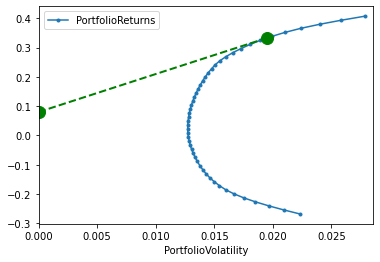

In [34]:
ax = efficient_frontier_df.plot.line(x="PortfolioVolatility", y="PortfolioReturns", style=".-")
ax.set_xlim(left = 0)
cml_x = [0, msr_volatility]
cml_y = [user_input["risk_free_rate"], msr_return]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

## Add custom weights on efficient frontier

In [35]:
msr_weights

array([7.49262869e-02, 2.84435642e-02, 2.12016138e-14, 6.21646758e-14,
       5.29403859e-01, 3.67226289e-01, 6.71314248e-15, 2.41091756e-13,
       1.74953636e-14])

In [36]:
equal_weights = np.repeat(1/df.shape[1], df.shape[1])

In [37]:
ew_return = portfolio_return(equal_weights, annulized_returns)
ew_vol = portfolio_vol(equal_weights, returns.cov())

In [38]:
ew_vol

0.014457749813474976

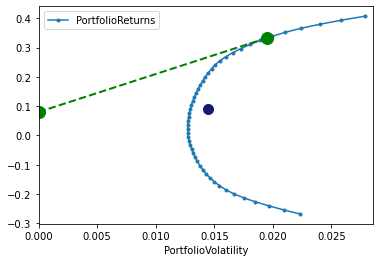

In [39]:
ax = efficient_frontier_df.plot.line(x="PortfolioVolatility", y="PortfolioReturns", style=".-")
ax.set_xlim(left = 0)
cml_x = [0, msr_volatility]
cml_y = [user_input["risk_free_rate"], msr_return]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

ax.plot([ew_vol], [ew_return], color='midnightblue', marker='o', markersize=10)

### Global Minium Variance Portfolio

In [40]:
# Assuming all returns are same, so maximum sharpe ratio will be according to lowest volatility
gmv_weights = max_sharp_ratio(np.repeat(1, df.shape[1]), returns.cov())

In [41]:
gmv_return = portfolio_return(gmv_weights, annulized_returns)
gmv_vol = portfolio_vol(gmv_weights, returns.cov())

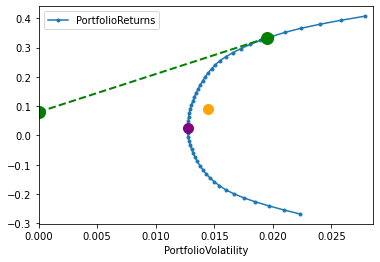

In [42]:
ax = efficient_frontier_df.plot.line(x="PortfolioVolatility", y="PortfolioReturns", style=".-")
ax.set_xlim(left = 0)
cml_x = [0, msr_volatility]
cml_y = [user_input["risk_free_rate"], msr_return]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

ax.plot([ew_vol], [ew_return], color='orange', marker='o', markersize=10)
ax.plot([gmv_vol], [gmv_return], color='purple', marker='o', markersize=10)